# Credit Card Fraud Detection

## Dataset
We will look at a dataset of credit card transactions, where some have been detected and marked to be fraudulent. We will investigate the extent to which this dataset can help detect fraudulent transactions.

First we will import the modules that we will need to analyse our dataset.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Next we will read the dataset, currently saved in the same directory as the .ipynb file. This may be better to optimise eventually. To read the csv file, we will use the pandas module that we previously imported.

In [28]:
df = pd.read_csv('creditcard.csv')
df.loc[:,['Time','V1','V28','Amount','Class']].head() # We exclude V2-V27 to make it more readable

,Time,V1,V28,Amount,Class
0,0.0,-1.359807,-0.021053,149.62,0
1,0.0,1.191857,0.014724,2.69,0
2,1.0,-1.358354,-0.059752,378.66,0
3,1.0,-0.966272,0.061458,123.50,0
4,2.0,-1.158233,0.215153,69.99,0


In [29]:
df.shape

(284807, 31)

We see that the dataset consists of 31 columns, or features, each with 284,807 entries. The features are as follows, taken from the source of the dataset, Kaggle.

| Column Name   | Feature Description                                 |
|---------------|-----------------------------------------------------|
| Time          | The seconds elapsed since the first transaction in the dataset and this one |
| V1-V28        | These are the principal components, anonymised for confidentiality |
| Amount        | The transaction amount                              |
| Class         | The response variable, 0 for normal, 1 for fraud    |

Next we'll take a closer look at the 3 variables that are named.

In [30]:
df[["Time","Amount","Class"]].describe()

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


From this we see that both **Time** and **Amount** vary a fair amount, and the summary for **Class** doesn't seem very useful. This makes sense as we know that it only takes 2 values. The very low mean does suggest that the data is heavily skewed, we will look more into this. The data for **Time** also suggests that there were periods where more transactions came through. Let's plot these to get a better look.

Text(0.5, 1.0, 'Fraud Response, 0 = Normal, 1 = Fraud')

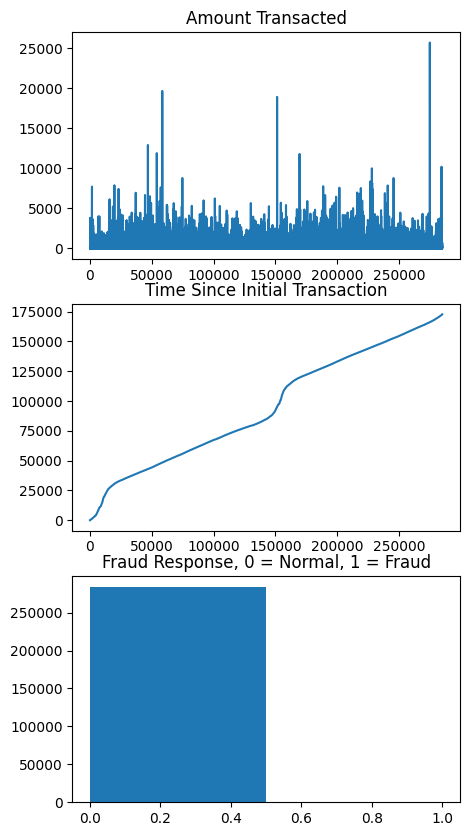

In [31]:
fig = plt.figure(figsize=(5,10))

ax1, ax2, ax3 = fig.subplots(3)
amount_vals = df['Amount'].values
time_vals = df['Time'].values
class_vals = df['Class'].values

ax1.plot(amount_vals)
ax1.set_title('Amount Transacted')
ax2.plot(time_vals)
ax2.set_title('Time Since Initial Transaction')
ax3.hist(class_vals,bins = 2)
ax3.set_title('Fraud Response, 0 = Normal, 1 = Fraud')

From the plot for **Amount**, we see that the majority of the transactions were a fairly low amount of money. This is supported by the mean gathered previously, which was 88.35 to 2 decimal places.

Next, the plot for **Time** tells us that there were indeed periods of increased activity, whilst the rest was roughly linear. From inspection of the graph, these periods of increased activity occur at around 10,000 and then 150,000 seconds.

Finally, from the plot for **Class**, we see that the data is in fact heavily skewed, with the bar for the fraudulent cases barely visible, if at all. If we take a look back to the mean gathered before, which was $0.001727$, this shows that only 0.1727% of the transactions have been identified as fraudulent. We can check this more rigorously.

In [32]:
fraudcount = len([x for x in df['Class'] if x == 1])
totalcount = (df.shape)[0]
print('There are {} fraudulent cases, so out of the {} total cases, that gives {:.4f}% of the cases as fraudulent.'
      .format(fraudcount,totalcount,100*fraudcount/totalcount))

There are 492 fraudulent cases, so out of the 284807 total cases, that gives 0.1727% of the cases as fraudulent.


Having data this skewed can make it difficult to train predictive models since there are so few fraudulent cases to train them on. One way of dealing with this is explored in the Kaggle notebook called **'Credit Fraud || Dealing with Imbalanced Datasets'** by Janio Martinez Bachmann, found [here](https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets#notebook-container). The way that Bachmann deals with the imbalance in the data, is by taking a random subsample of the non-fraudulent cases of the same size as the fraudulent cases, i.e. 492 non-fraudulent cases, compared against the 492 fraudulent cases. Firstly, however, he scales the data in the **Time** and **Amount** features, in a similar way that the **V1-V28** features have been scaled.

From here on, all comments in the coding are my own, whilst the code itself is taken from Bachmann's Kaggle code.

In [33]:
# First he imports this package, one that allows for easy scaling of data. It scales the data to have mean 0 and variance 1.
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

# These next lines add the scaled data onto the end of the dataframe.
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# The unscaled data is then dropped.
df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

# And then replaced by moving the scaled data to the front of the dataframe.
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# The data is now scaled
df.loc[:,['scaled_amount','scaled_time','V1','V28','Class']].head() # Where we again exclude V2-V27 to make things more readable.

,scaled_amount,scaled_time,V1,V28,Class
0,1.783274,-0.994983,-1.359807,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.014724,0
2,4.983721,-0.994972,-1.358354,-0.059752,0
3,1.418291,-0.994972,-0.966272,0.061458,0
4,0.670579,-0.994960,-1.158233,0.215153,0


Now that the data is scaled, he creates the subsample.

In [34]:
# First he randomly shuffles the data.
df = df.sample(frac=1)

# Then he isolated the fraudulent data, and creates the non-fraud subsample, then concatinates them.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Then once again shuffles the data.
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.loc[:,['scaled_amount','scaled_time','V1','V28','Class']].head() # Where we again exclude V2-V27 to make things more readable.

,scaled_amount,scaled_time,V1,V28,Class
96622,-0.252079,-0.221314,-2.183873,-0.375991,0
245556,4.694334,0.800174,1.322724,0.072386,1
51482,1.260113,-0.466676,1.025895,0.017560,0
42769,1.345630,-0.510521,-10.281784,-0.485552,1
189701,0.996996,0.514891,-4.599447,1.231425,1


With this new subsample, Bachmann runs a correlation matrix to hopefully get an idea of any correlation between the **Class** (i.e. fraudulent or not) and any of the other features.

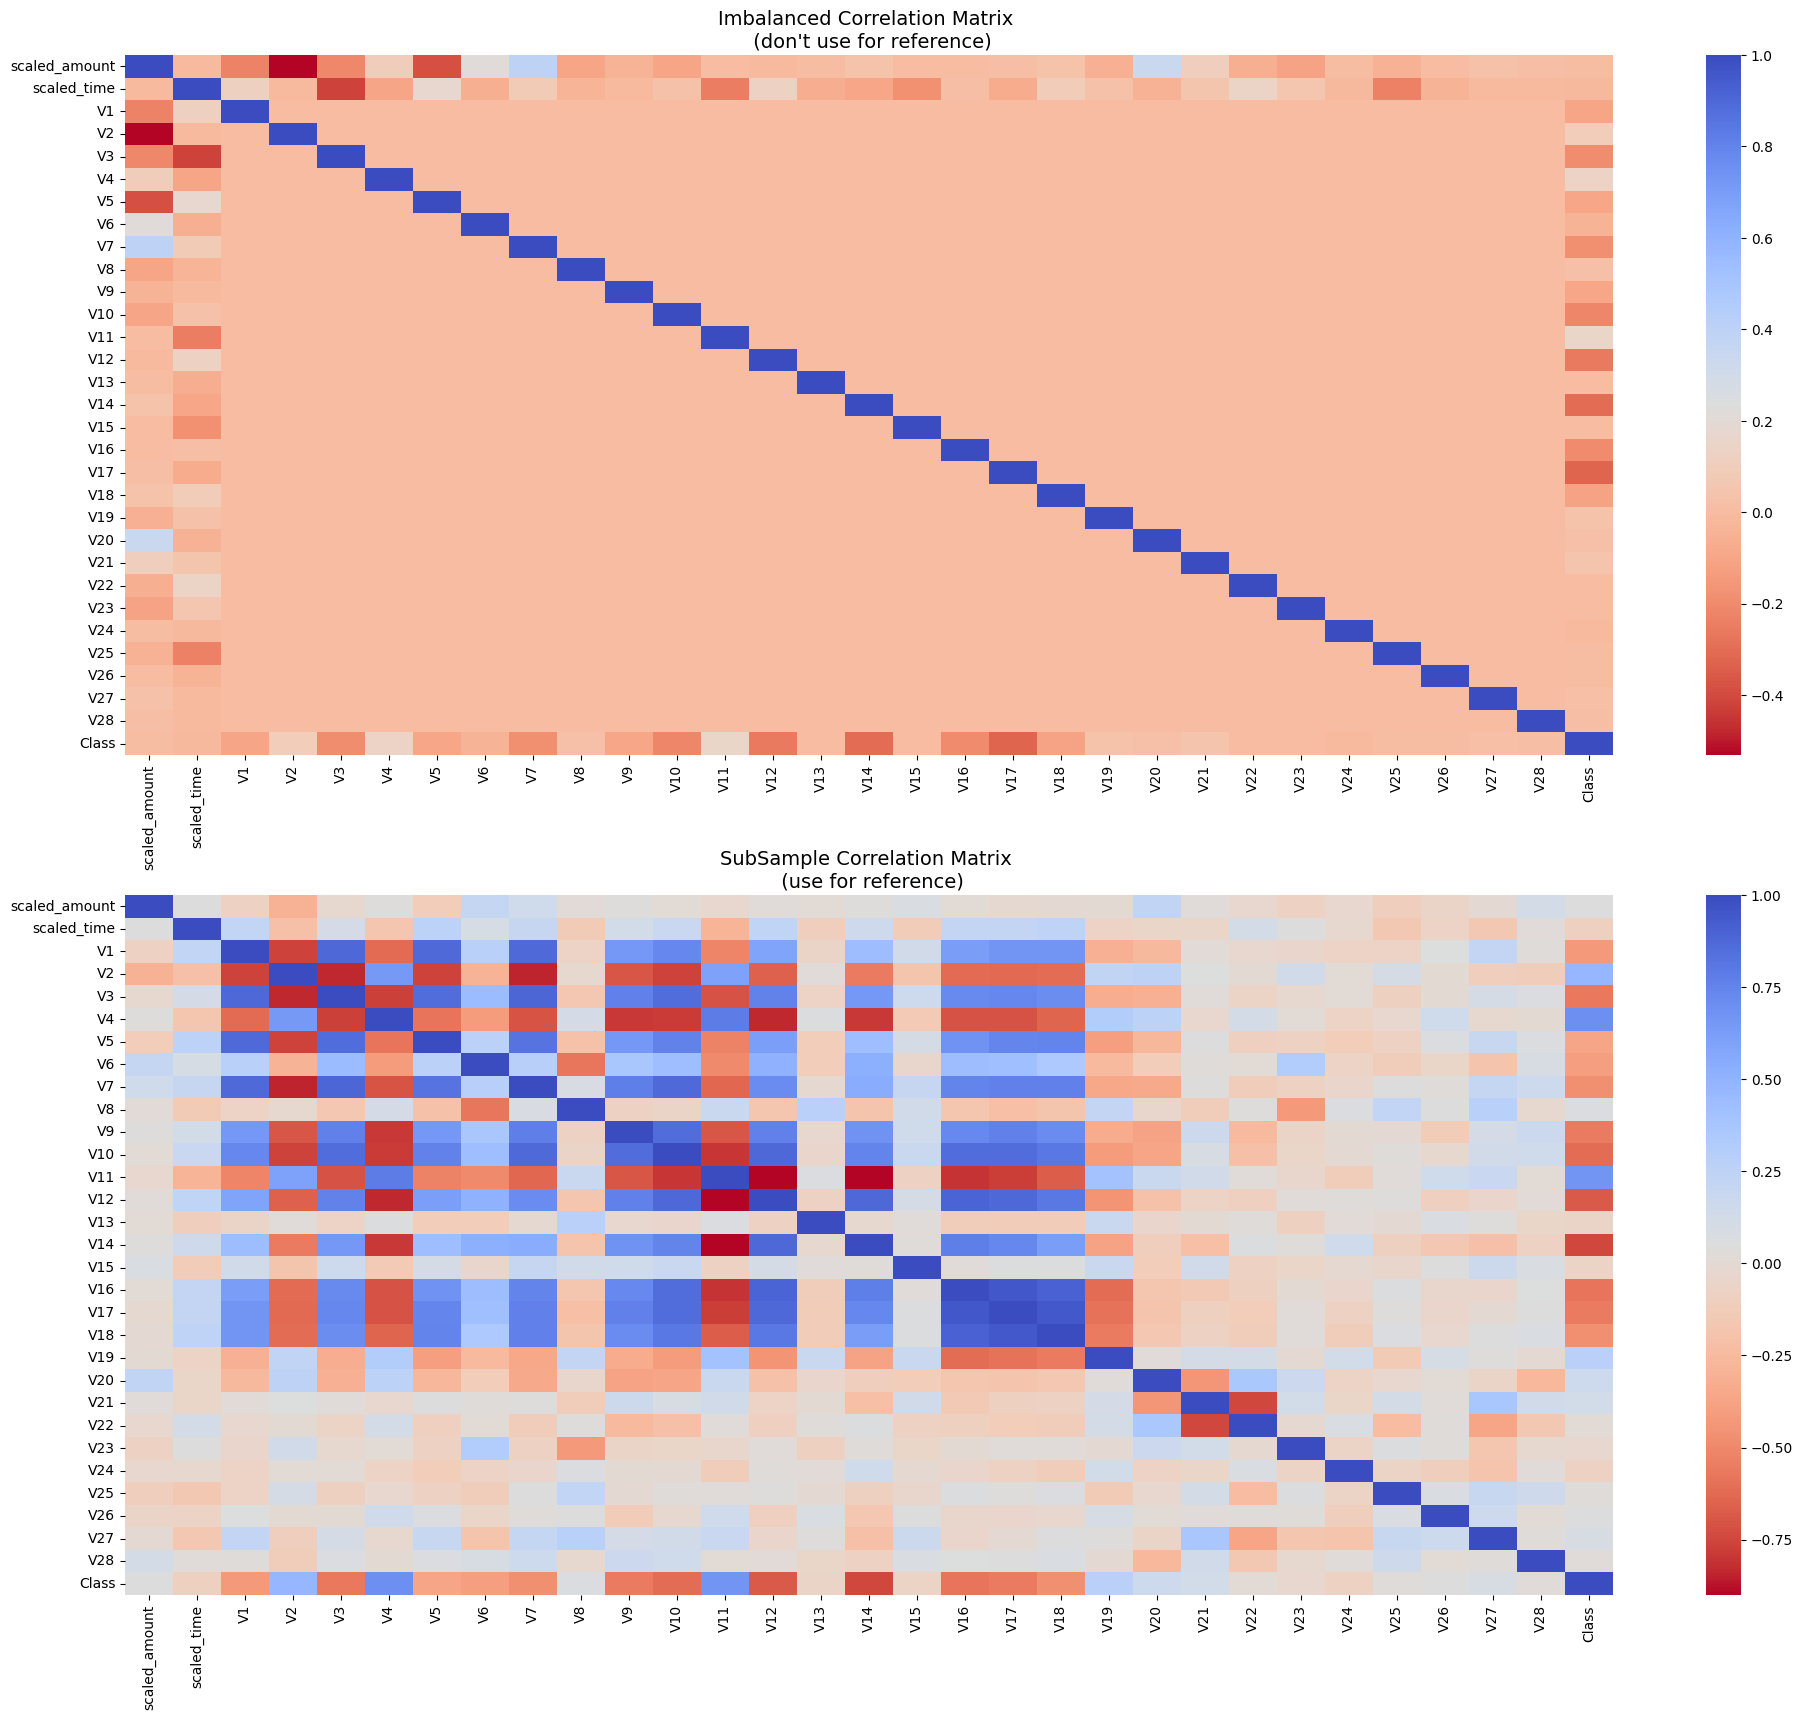

In [35]:
# First create the figure.
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# This plot is a correlation matrix for the entire dataframe, before he had gathered the subsample.
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# This plot is a correlation matrix for the subsample.
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

These correlation matrices are strikingly different, and it is clear that creating the subsample was incredibly important for this dataset. The whole dataframe in the first plot does not show any clear correlation. This is because training on an overabundance of non-fraudulent cases makes the method expect that most cases are fraudulent, whilst training on the equal distribution subsample trains it to equally detect fraudulent and non-fraudulent.

From Bachmann's own investigation of this second correlation matrix, he concludes that **V17, V14, V12, and V10** all show clear negative correlation, whilst **V2, V4, V11, and V19** all show clear positive correlation. This can be seen clearly by inspecting the final row or column, wich show's the correlation between the **Class** feature and the other features.

Whilst Bachmann's analysis goes much further than this, this notebook will stop here. I think that this brief analysis shows the significance of understanding and manipulating the data available to improve the models that you apply to it, you cannot merely go in blindly and hope that the model will do all the work for you, as this will not give any usable results.